## General information

In this kernel I work with data from 2019 Data Science Bowl Challenge.

This is quite an interesting data about children playing educational games. We need to predict how will a user perform in the next assessment.

I have decided to try a different approach to feature engineering and modelling in this kernel - most of the code will be written in classes for better usability and reproducibility. These are my first attempts to do it on Kaggle, so the code may evolve into something different in the future.


![](https://i.imgur.com/ysD3pe0.png)

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from tqdm import tqdm
from joblib import Parallel, delayed

Using TensorFlow backend.


## Helper functions and classes

In [2]:
def add_datepart(df: pd.DataFrame, field_name: str,
                 prefix: str = None, drop: bool = True, time: bool = True, date: bool = True):
    """
    Helper function that adds columns relevant to a date in the column `field_name` of `df`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/tabular/transform.py#L55
    """
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start']
    if date:
        attr.append('Date')
    if time:
        attr = attr + ['Hour', 'Minute']
    for n in attr:
        df[prefix + n] = getattr(field.dt, n.lower())
    if drop:
        df.drop(field_name, axis=1, inplace=True)
    return df


def ifnone(a: Any, b: Any) -> Any:
    """`a` if `a` is not None, otherwise `b`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/core.py#L92"""
    return b if a is None else a

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    """
    A wrapper for xgboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)




class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

        data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
        data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
        data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

        data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
                         or 'attempt' in col]

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [4]:
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 4# 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, self.oof.argmax(1)), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof.argmax(1))
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
            X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [5]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):
        """
        Categorical transformer. This is a wrapper for categorical encoders.

        :param cat_cols:
        :param drop_original:
        :param encoder:
        """
        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

## Data overview

Let's have a look at the data at first.

In [6]:
path = '/kaggle/input/data-science-bowl-2019'
specs = pd.read_csv(f'{path}/specs.csv')
sample_submission = pd.read_csv(f'{path}/sample_submission.csv')
train_labels = pd.read_csv(f'{path}/train_labels.csv')
test = pd.read_csv(f'{path}/test.csv')
train = pd.read_csv(f'{path}/train.csv')

In [7]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [8]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [9]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [10]:
print(f'Rows in train data: {train.shape[0]}')
print(f'Rows in train labels: {train_labels.shape[0]}')
print(f'Rows in specs data: {specs.shape[0]}')

Rows in train data: 11341042
Rows in train labels: 17690
Rows in specs data: 386


As we can see, the train dataset has more than 11 millions of rows, but there are only ~18k rows with labels. Now we need to find the correct way of combining data with labels.

Let's read the description of the data, particulary at the following:

```
For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

```

What can we infer from this information?
- We predict one value/class per installment - for the last assessment;
- Not all installment in train dataset are present in labels;
- Only events with certain event codes have labels;
- In train data we can have several labels for one installment;

## The main idea of data transformation

I have read most of public kernels and think that a different approach for data transformation is necessary.
We don't simply predict a label for some assessment of a user: we predict a label for a **future** assessment. This means that when we make a prediction for the test data, we have only data about user activity **up to** the timestamp of the assessment. And, of course, we don't have any information about how user performs in the assessment (we hame only one row - the start of the assessment).

As a result, if we want to create a good training dataset without leaks, we need to loop over `train_labels` and generate features only on the rows, which are before start of the particular assessment.

### Preparing the data


In [11]:
# rows with attempts
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['attempt'] = 0
train.loc[(train['title'] == 'Bird Measurer (Assessment)') & (train['event_code'] == 4110),
       'attempt'] = 1
train.loc[(train['type'] == 'Assessment') &
       (train['title'] != 'Bird Measurer (Assessment)')
       & (train['event_code'] == 4100), 'attempt'] = 1

title_oe = OrdinalEncoder()
title_oe.fit(list(set(train['title'].unique()).union(set(test['title'].unique()))));
world_oe = OrdinalEncoder()
world_oe.fit(list(set(train['world'].unique()).union(set(test['world'].unique()))));

train['correct'] = None
train.loc[(train['attempt'] == 1) & (train['event_data'].str.contains('"correct":true')), 'correct'] = True
train.loc[(train['attempt'] == 1) & (train['event_data'].str.contains('"correct":false')), 'correct'] = False

train['title'] = title_oe.transform(train['title'].values)
train['world'] = world_oe.transform(train['world'].values)
train = train.loc[train['installation_id'].isin(train_labels['installation_id'].unique())]

## Class for generating features

In the hidden cell below you can find a class for feature generation.

In [12]:
class FeatureGenerator(object):
    def __init__(self, n_jobs=1, df=None, dataset: str = 'train'):
        self.n_jobs = n_jobs
        self.df = df
        self.dataset = dataset

    def read_chunks(self):
        for id, user_sample in self.df.groupby('installation_id', sort=False):
            yield id, user_sample

    def get_features(self, row):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        return self.features(row)

    def features(self, id, user_sample):
        user_data = []

        accuracy_mapping = {0: 0, 1: 3, 0.5: 2}

        user_stats = defaultdict(int)
        user_stats['installation_id'] = user_sample['installation_id'].unique()[0]
        user_stats['world'] = user_sample['world'].unique()[0]
        user_stats['timestamp'] = user_sample['timestamp'].unique()[0]

        temp_dict = defaultdict(int)
        another_temp_dict = {}
        another_temp_dict['durations'] = []
        another_temp_dict['all_durations'] = []
        another_temp_dict['durations_with_attempts'] = []
        another_temp_dict['mean_action_time'] = []
        title_data = defaultdict(dict)

        for i, session in user_sample.groupby('game_session', sort=False):
            user_stats['last_ass_session_game_time'] = another_temp_dict['durations'][-1] if len(another_temp_dict['durations']) > 0 else 0
            user_stats['last_session_game_time'] = another_temp_dict['all_durations'][-1] if len(another_temp_dict['all_durations']) > 0 else 0

            # calculate some user_stats and append data
            if session['attempt'].sum() > 0 or self.dataset == 'test':
                user_stats['session_title'] = session['title'].values[0]
                accuracy = np.nan_to_num(session['correct'].sum() / session['attempt'].sum())
                if accuracy in accuracy_mapping.keys():
                    user_stats['accuracy_group'] = accuracy_mapping[accuracy]
                else:
                    user_stats['accuracy_group'] = 1
                user_stats['accumulated_accuracy_group'] = temp_dict['accumulated_accuracy_group'] / user_stats['counter'] if user_stats['counter'] > 0 else 0
                temp_dict['accumulated_accuracy_group'] += user_stats['accuracy_group']
                user_data.append(copy.copy(user_stats))

            user_stats[session['type'].values[-1]] += 1
            user_stats['accumulated_correct_attempts'] += session['correct'].sum()
            user_stats['accumulated_uncorrect_attempts'] += session['attempt'].sum() - session['correct'].sum()
            event_code_counts = session['event_code'].value_counts()
            for i, j in zip(event_code_counts.index, event_code_counts.values):
                user_stats[i] += j

            temp_dict['assessment_counter'] += 1
            if session['title'].values[-1] in title_data.keys():
                pass
            else:
                title_data[session['title'].values[-1]] = defaultdict(int)

            title_data[session['title'].values[-1]]['duration_all'] += session['game_time'].values[-1]
            title_data[session['title'].values[-1]]['counter_all'] += 1
            #user_stats['duration'] += (session['timestamp'].values[-1] - session['timestamp'].values[0]) / np.timedelta64(1, 's')

            user_stats['duration'] = (session.iloc[-1,2] - session.iloc[0,2]).seconds
            if session['type'].values[0] == 'Assessment' and (len(session) > 1 or self.dataset == 'test'):
                another_temp_dict['durations'].append(user_stats['duration'])
                accuracy = np.nan_to_num(session['correct'].sum() / session['attempt'].sum())
                user_stats['accumulated_accuracy_'] += accuracy
                user_stats['counter'] += 1
                if user_stats['counter'] == 0:
                    user_stats['accumulated_accuracy'] = 0
                else:
                    user_stats['accumulated_accuracy'] = user_stats['accumulated_accuracy_'] / user_stats['counter']

                accuracy = np.nan_to_num(session['correct'].sum() / session['attempt'].sum())

                if accuracy in accuracy_mapping.keys():
                    user_stats[accuracy_mapping[accuracy]] += 1
                else:
                    user_stats[1] += 1

                user_stats['accumulated_actions'] += len(session)

                if session['attempt'].sum() > 0:
                    user_stats['sessions_with_attempts'] += 1
                    another_temp_dict['durations_with_attempts'].append(user_stats['duration'])

                if session['correct'].sum() > 0:
                    user_stats['sessions_with_correct_attempts'] += 1
                    
                user_stats['title_duration'] = title_data[session['title'].values[-1]]['duration']
                user_stats['title_counter'] = title_data[session['title'].values[-1]]['counter']
                user_stats['title_mean_duration'] = user_stats['title_duration'] / user_stats['title_mean_duration']  if user_stats['title_mean_duration'] > 0 else 0

                user_stats['title_duration_all'] = title_data[session['title'].values[-1]]['duration_all']
                user_stats['title_counter_all'] = title_data[session['title'].values[-1]]['counter_all']
                user_stats['title_mean_duration_all'] = user_stats['title_duration_all'] / user_stats['title_mean_duration_all']  if user_stats['title_mean_duration_all'] > 0 else 0
                
                title_data[session['title'].values[-1]]['duration'] += session['game_time'].values[-1]
                title_data[session['title'].values[-1]]['counter'] += 1

            elif (len(session) > 1 or self.dataset == 'test'):
                another_temp_dict['all_durations'].append(user_stats['duration'])


            if user_stats['duration'] != 0:
                temp_dict['nonzero_duration_assessment_counter'] += 1
            #user_stats['duration_mean'] = user_stats['duration'] / max(temp_dict['nonzero_duration_assessment_counter'], 1)
            # stats from assessment sessions
            user_stats['duration_mean'] = np.mean(another_temp_dict['durations'])
            user_stats['duration_attempts'] = np.mean(another_temp_dict['durations_with_attempts'])

            # stats from all sessions
            user_stats['all_duration_mean'] = np.mean(another_temp_dict['all_durations'])
            user_stats['all_accumulated_actions'] += len(session)
            user_stats['mean_action_time'] = np.mean(another_temp_dict['mean_action_time'])
            another_temp_dict['mean_action_time'].append(session['game_time'].values[-1] / len(session))


        if self.dataset == 'test':
            user_data = [user_data[-1]]

        return user_data

    def generate(self):
        feature_list = []
#         res = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.features)(id, user_sample)
#                                                                 for id, user_sample in tqdm(self.read_chunks(),
#                                                                                             total=self.df[
#                                                                                                 'installation_id'].nunique()))
        res = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.features)(id, user_sample)
                                                                for id, user_sample in self.read_chunks())
        for r in res:
            for r1 in r:
                feature_list.append(r1)
        return pd.DataFrame(feature_list)

In [13]:
%%time
fg = FeatureGenerator(n_jobs=2, df=train)
data = fg.generate()
data = data.fillna(0)

CPU times: user 10min 46s, sys: 59.3 s, total: 11min 45s
Wall time: 10min 29s


In [14]:
data.head()

,installation_id,world,timestamp,last_ass_session_game_time,last_session_game_time,Clip,accumulated_correct_attempts,accumulated_uncorrect_attempts,2000,duration,...,4220,4045,4095,2,2075,4230,4235,4050,1,4080
0,0006a69f,3,2019-08-06 04:57:18.904000+00:00,0,164,11.0,0.0,0.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0006a69f,3,2019-08-06 04:57:18.904000+00:00,39,104,14.0,1.0,0.0,25.0,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0006a69f,3,2019-08-06 04:57:18.904000+00:00,92,104,14.0,1.0,11.0,26.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0006a69f,3,2019-08-06 04:57:18.904000+00:00,8,90,24.0,2.0,11.0,47.0,8.0,...,9.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0006a69f,3,2019-08-06 04:57:18.904000+00:00,31,80,28.0,3.0,12.0,56.0,80.0,...,9.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
del train, train_labels

In [16]:
data = add_datepart(data, 'timestamp', drop=False)

In [17]:
# getting constant columns
bad_cols = []
for col in data:
    if data[col].nunique() <= 1:
        print(col)
        bad_cols.append(col)

title_mean_duration
title_mean_duration_all
timestampYear


## Training

Here I'll also use classes for training the data. The code works like this:
- MainTransformer does some general processing on all the data - for example, processing cyclical features, creating feature interactions and so on;
- transformers do some processing on folds - for example mean encoding. In the current dataset it generates aggregated features on folds.
- LGBWrapper is a wrapper over LGBM. This wrapper is necessary, so that all models have a similar API and it is easier to use them;
- ClassifierModel is the main class for modelling: it trains, applies and saves transformers, it trains and saves the models, plots the results and so on. It is also quite convenient to use in kaggle kernels, because we can train it on the train data (without loading test data) and then we can delete all the train data and apply ClassifierModel to test data.

In [18]:
param = {'n_estimators':2000,
         'learning_rate': 0.01,
         'metric': 'multiclass',
         'objective': 'multiclass',
         'max_depth': 15,
         'num_classes': 4,
         'feature_fraction': 0.85,
         'subsample': 0.85,
         'verbose': 1000,
         'early_stopping_rounds': 100, 'eval_metric': 'cappa'
        }

In [19]:
y = data['accuracy_group']

In [20]:
n_fold = 5
#folds = StratifiedKFold(n_splits=n_fold)
#folds = KFold(n_splits=n_fold)
folds = RepeatedStratifiedKFold(n_splits=n_fold)
folds = GroupKFold(n_splits=n_fold)

In [21]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate'] + bad_cols

In [22]:
data.columns = [str(col) for col in data.columns]

Fold 1 started at Mon Nov 18 03:26:44 2019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	train's multi_logloss: 0.893118	train's cappa: 0.564589	valid's multi_logloss: 1.00773	valid's cappa: 0.532419
Fold 2 started at Mon Nov 18 03:27:10 2019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[532]	train's multi_logloss: 0.822857	train's cappa: 0.606654	valid's multi_logloss: 0.986842	valid's cappa: 0.535795
Fold 3 started at Mon Nov 18 03:27:42 2019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	train's multi_logloss: 0.779998	train's cappa: 0.629137	valid's multi_logloss: 1.00891	valid's cappa: 0.515263
Fold 4 started at Mon Nov 18 03:28:21 2019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	train's multi_logloss: 0.791467	train's cappa: 0.623146	valid's multi_logloss: 1.0

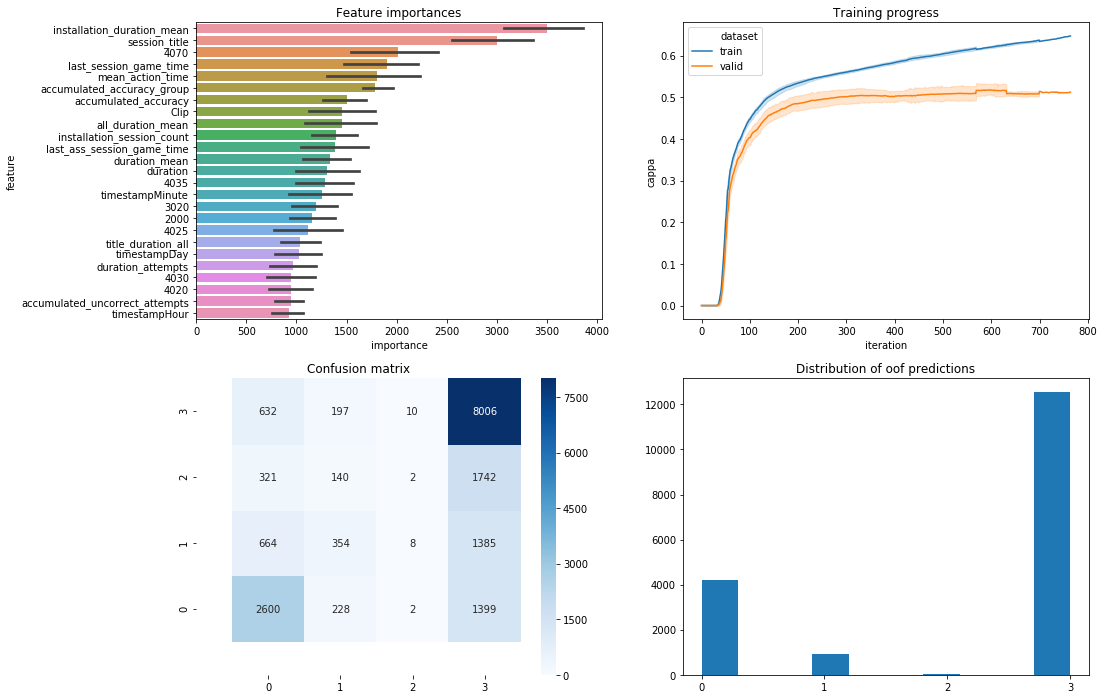

In [23]:
cat_cols = ['world']
mt = MainTransformer(create_interactions=False)
ct = CategoricalTransformer(drop_original=True, cat_cols=cat_cols)
ft = FeatureTransformer()
transformers = {'ft': ft, 'ct': ct}
lgb_model = ClassifierModel(model_wrapper=LGBWrapper())
lgb_model.fit(X=data, y=y, folds=folds, params=param, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

## Training xgb

I want to note that custom xgb metric is always minimized, so I had to return negative cappa score.

Fold 1 started at Mon Nov 18 03:29:58 2019
[0]	validation_0-merror:0.362705	validation_1-merror:0.393443	validation_0-cappa:-0.533536	validation_1-cappa:-0.490787
Multiple eval metrics have been passed: 'validation_1-cappa' will be used for early stopping.

Will train until validation_1-cappa hasn't improved in 100 rounds.
Stopping. Best iteration:
[27]	validation_0-merror:0.333522	validation_1-merror:0.371962	validation_0-cappa:-0.583869	validation_1-cappa:-0.550034

Fold 2 started at Mon Nov 18 03:30:21 2019
[0]	validation_0-merror:0.362564	validation_1-merror:0.398813	validation_0-cappa:-0.541782	validation_1-cappa:-0.46231
Multiple eval metrics have been passed: 'validation_1-cappa' will be used for early stopping.

Will train until validation_1-cappa hasn't improved in 100 rounds.
Stopping. Best iteration:
[265]	validation_0-merror:0.192128	validation_1-merror:0.36433	validation_0-cappa:-0.774671	validation_1-cappa:-0.546722

Fold 3 started at Mon Nov 18 03:31:22 2019
[0]	validati

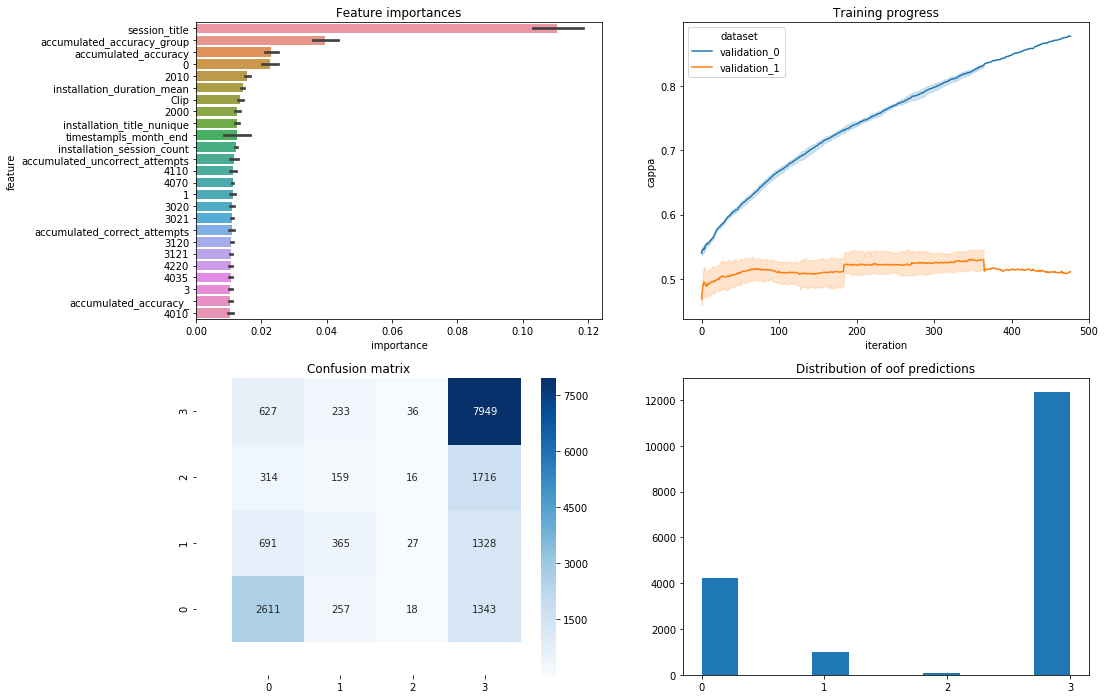

In [24]:
xgb_params = {
        'colsample_bytree': 0.8,
        'learning_rate': 0.05,
        'max_depth': 7,
        'subsample': 1,
        'objective':'multi:softprob',
        'num_class':4,
        'eval_metric':'merror',
        'min_child_weight':10,
        'gamma':0.25,
        'n_estimators':500,
        'nthread': 6,
        'verbose': 1000,
        'early_stopping_rounds': 100,
    }
folds = GroupKFold(n_splits=5)
cat_cols = ['world']
mt = MainTransformer(create_interactions=False)
ct = CategoricalTransformer(drop_original=True, cat_cols=cat_cols)
ft = FeatureTransformer()
transformers = {'ft': ft, 'ct': ct}
xgb_model = ClassifierModel(model_wrapper=XGBWrapper())
xgb_model.fit(X=data, y=y, folds=folds, params=xgb_params, preprocesser=mt, transformers=transformers,
              eval_metric='cappa', cols_to_drop=cols_to_drop)

## Training catboost

Fold 1 started at Mon Nov 18 03:34:15 2019
0:	learn: 0.4522477	test: 0.4562936	test1: 0.4616958	best: 0.4616958 (0)	total: 148ms	remaining: 4m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5133305743
bestIteration = 1

Shrink model to first 2 iterations.
Fold 2 started at Mon Nov 18 03:34:22 2019
0:	learn: 0.4215725	test: 0.4556061	test1: 0.4629260	best: 0.4629260 (0)	total: 73.8ms	remaining: 2m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4888901448
bestIteration = 1

Shrink model to first 2 iterations.
Fold 3 started at Mon Nov 18 03:34:29 2019
0:	learn: 0.4462962	test: 0.4643681	test1: 0.4403649	best: 0.4403649 (0)	total: 76.6ms	remaining: 2m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4656982987
bestIteration = 122

Shrink model to first 123 iterations.
Fold 4 started at Mon Nov 18 03:34:45 2019
0:	learn: 0.4413515	test: 0.4508378	test1: 0.4347409	best: 0.4347409 (0)	total: 74.5ms	remaining: 2m 28s


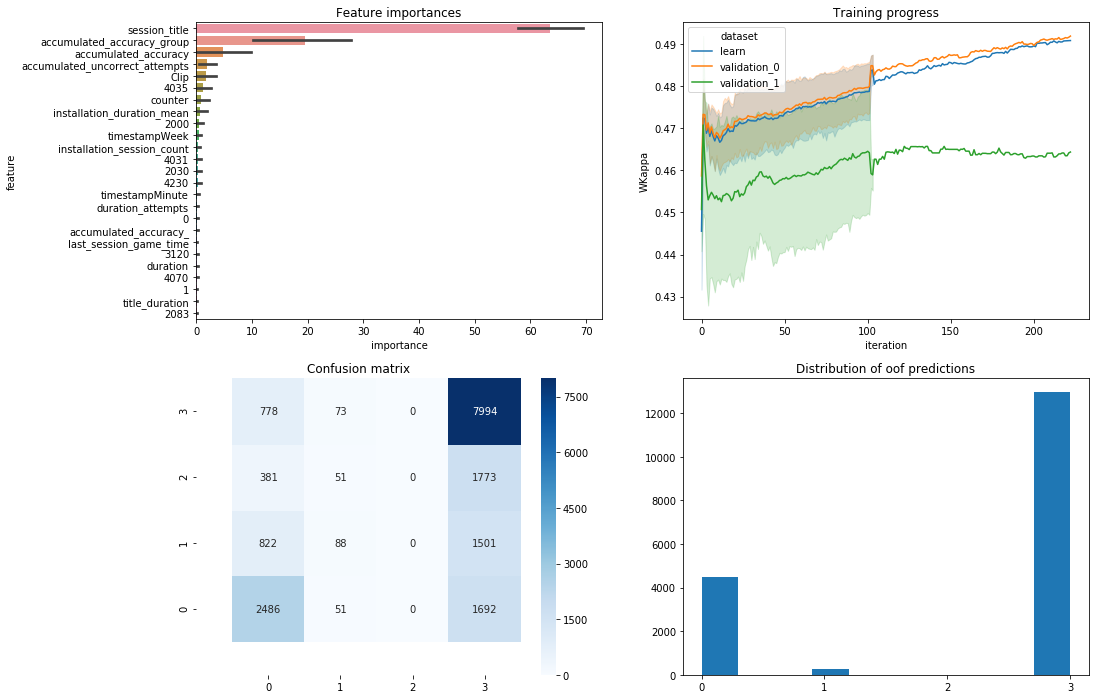

In [25]:
cat_params = {'loss_function': 'MultiClass',
          'eval_metric':"WKappa",
          'task_type': "CPU",
          'iterations': 2000,
          'learning_rate': 0.01,
          'verbose': 500,
          'early_stopping_rounds': 100,
          'cat_cols': ['world_encoded', 'session_title'],
          'od_type': 'Iter',
          'early_stopping_rounds': 100
    }
folds = GroupKFold(n_splits=5)
cat_cols = ['world']
mt = MainTransformer(create_interactions=False)
ct = CategoricalTransformer(drop_original=True, cat_cols=cat_cols)
ft = FeatureTransformer()
transformers = {'ft': ft, 'ct': ct}
cat_model = ClassifierModel(model_wrapper=CatWrapper())
cat_model.fit(X=data, y=y, folds=folds, params=cat_params, preprocesser=mt, transformers=transformers,
              eval_metric='WKappa', cols_to_drop=cols_to_drop)

## Making predictions

In [26]:
del data
del y

In [27]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
# rows with attempts
test['attempt'] = 0
test.loc[(test['title'] == 'Bird Measurer (Assessment)') & (test['event_code'] == 4110),
       'attempt'] = 1
test.loc[(test['type'] == 'Assessment') &
       (test['title'] != 'Bird Measurer (Assessment)')
       & (test['event_code'] == 4100), 'attempt'] = 1

test['correct'] = None
test.loc[(test['attempt'] == 1) & (test['event_data'].str.contains('"correct":true')), 'correct'] = True
test.loc[(test['attempt'] == 1) & (test['event_data'].str.contains('"correct":false')), 'correct'] = False

test['title'] = title_oe.transform(test['title'].values)
test['world'] = world_oe.transform(test['world'].values)

In [28]:
%%time
fg = FeatureGenerator(n_jobs=2, df=test, dataset='test')
test_data = fg.generate()
test_data.columns = [str(col) for col in test_data.columns]
test_data = test_data.fillna(0)
test_data = add_datepart(test_data, 'timestamp', drop=False)

CPU times: user 2min 2s, sys: 10.8 s, total: 2min 13s
Wall time: 1min 59s


In [29]:
prediction = cat_model.predict(test_data) + lgb_model.predict(test_data) + xgb_model.predict(test_data)

In [30]:
sample_submission['accuracy_group'] = prediction.argmax(1)
sample_submission.to_csv('submission.csv', index=False)

In [31]:
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.719
0    0.243
1    0.038
Name: accuracy_group, dtype: float64